In [1]:
from pathlib import Path
from time import time

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from kgi import apply_kgi_to_layer

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# attempt to enable LaTeX rendering
# change to `False` if you get an error during plotting (latex not installed)
plt.rcParams['text.usetex'] = True

# Problem

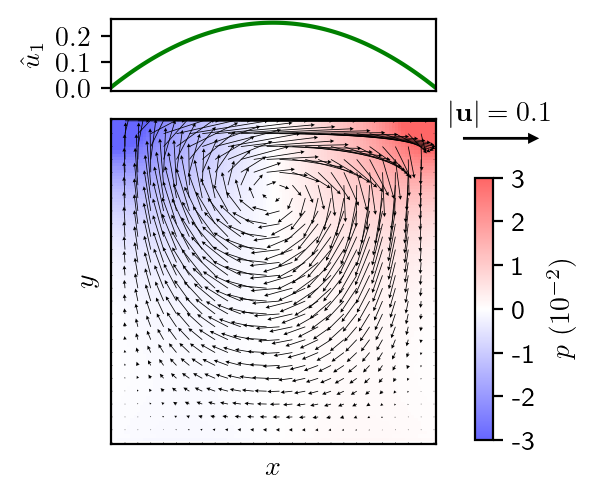

In [3]:
# data
n_pts_edge = 101  # using the size of true solution, but this is unnecessary
eval_pts = np.linspace(0, 1, num=n_pts_edge)[:, None]
xv, yv = np.meshgrid(eval_pts[:, 0], eval_pts[:, 0], indexing='ij')
sol_true = np.load('./datasets/stokes.npz')['arr_0']
sol_true_grid = sol_true.reshape(n_pts_edge, n_pts_edge, 3)

# plot solution
fig, ax = plt.subplots(dpi=200, figsize=(3.5 / 1.2, 3.5 / 1.2))
p_plt = ax.imshow(sol_true_grid[:, :, 2].T, origin='lower',
                  vmin=-0.03, vmax=0.03, cmap="bwr", alpha=.6)
vec_space = 4
v_plt = ax.quiver(xv[::vec_space, ::vec_space] * 100,
                  yv[::vec_space, ::vec_space] * 100,
                  sol_true_grid[::vec_space, ::vec_space, 0],
                  sol_true_grid[::vec_space, ::vec_space, 1],
                  color="k", scale=.5, headwidth=5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

# legend and colorbar
ax.annotate('', xy=(0.885 + .100 - .06, 0.57 + 0.05), xycoords='figure fraction',
            xytext=(0.768 + .085 - .06, 0.57 + 0.05), textcoords='figure fraction',
            arrowprops=dict(facecolor='k', edgecolor="none", shrink=0.005,
                            width=1, headwidth=4, headlength=4))
ax.text(105, 100, '$|\\mathbf{u}|=0.1$')
plt.tight_layout()
cb_ax = fig.add_axes([.77, 0.12, 0.03, 0.45])
cbar = fig.colorbar(p_plt, cax=cb_ax, label='$p\\ (10^{-2})$')
cbar.set_ticks(np.arange(-.03, .031, 0.01))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x_, _: f'{round(x_ * 100)}'))

# boundary condition
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("top", size=0.8, pad=-0.08)
ax2.plot(sol_true_grid[:, -1, 0], c='g')
ax2.set_aspect(80)
ax2.set_xlim(0, 100)
ax2.set_xticks([])
ax2.set_yticks([0, .1, .2])
ax2.set_ylabel("$\hat u_1$")
plt.savefig("figs/deeponet_problem.pdf", bbox_inches='tight')
plt.show()

# PDE components

In [4]:
# PDE equation
def pde(xy, uvp, _):
    mu = 0.01
    u, v, p = uvp[..., 0:1], uvp[..., 1:2], uvp[..., 2:3]
    grad_u = dde.zcs.LazyGrad(xy, u)
    grad_v = dde.zcs.LazyGrad(xy, v)
    grad_p = dde.zcs.LazyGrad(xy, p)
    # first order
    du_x = grad_u.compute((1, 0))
    dv_y = grad_v.compute((0, 1))
    dp_x = grad_p.compute((1, 0))
    dp_y = grad_p.compute((0, 1))
    # second order
    du_xx = grad_u.compute((2, 0))
    du_yy = grad_u.compute((0, 2))
    dv_xx = grad_v.compute((2, 0))
    dv_yy = grad_v.compute((0, 2))
    motion_x = mu * (du_xx + du_yy) - dp_x
    motion_y = mu * (dv_xx + dv_yy) - dp_y
    mass = du_x + dv_y
    return motion_x, motion_y, mass


# Geometry
geom = dde.geometry.Rectangle([0, 0], [1, 1])


# Boundary condition
# other boundary conditions will be enforced by output transform
def bc_slip_top_func(x, aux_var):
    # using (perturbation / 10 + 1) * x * (1 - x)
    return (aux_var / 10 + 1.) * dde.backend.as_tensor(x[:, 0:1] * (1 - x[:, 0:1]))  # noqa


bc_slip_top = dde.icbc.DirichletBC(
    geom=geom,
    func=bc_slip_top_func,
    on_boundary=lambda x, on_boundary: np.isclose(x[1], 1.),
    component=0)

# PDE object
pde = dde.data.PDE(
    geom,
    pde,
    bcs=[bc_slip_top],
    num_domain=5000,
    num_boundary=4000,  # sampling a bit more points on boundary (1000 on top bc)
    num_test=500,
)

# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
data = dde.zcs.PDEOperatorCartesianProd(
    pde, func_space, eval_pts, num_function=1000,
    function_variables=[0], num_test=100, batch_size=50
)


# Output transform for zero boundary conditions
def out_transform(inputs, outputs):
    x, y = inputs[1][:, 0], inputs[1][:, 1]
    # horizontal velocity on left, right, bottom
    u = outputs[:, :, 0] * (x * (1 - x) * y)[None, :]
    # vertical velocity on all edges
    v = outputs[:, :, 1] * (x * (1 - x) * y * (1 - y))[None, :]
    # pressure on bottom
    p = outputs[:, :, 2] * y[None, :]
    return dde.backend.stack((u, v, p), axis=2)  # noqa

# Training

In [5]:
def train(kgi, seed=0, iterations=10000):
    torch.manual_seed(seed)
    # Net
    net = dde.nn.DeepONetCartesianProd(  # noqa
        [n_pts_edge, 128, 128, 128],
        [2, 128, 128, 128],
        "tanh",
        "Glorot normal",
        num_outputs=3,
        multi_output_strategy="independent"
    )
    net.apply_output_transform(out_transform)

    # KGI
    if kgi:
        for m in net.branch:
            apply_kgi_to_layer(m.linears[0], knot_low=-1.5, knot_high=1.5,
                               perturb_factor=0.2, kgi_by_bias=True)
            for i in range(1, len(m.linears)):
                apply_kgi_to_layer(m.linears[i], knot_low=-0.8, knot_high=0.8,
                                   perturb_factor=0.2, kgi_by_bias=True)
        for m in net.trunk:
            apply_kgi_to_layer(m.linears[0], knot_low=0.2, knot_high=0.8,
                               perturb_factor=0.2, kgi_by_bias=True)
            for i in range(1, len(m.linears)):
                apply_kgi_to_layer(m.linears[i], knot_low=-0.8, knot_high=0.8,
                                   perturb_factor=0.2, kgi_by_bias=True)

    # Model
    model = dde.zcs.Model(data, net)
    model.compile("adam", lr=0.001, decay=("inverse time", 10000, 0.5))
    loss_history, train_state = model.train(iterations=iterations, display_every=20)

    # Evaluation
    func_feats = func_space.random(1)
    v = func_space.eval_batch(func_feats, eval_pts)
    v[:] = 0.  # true solution uses zero perturbation
    xy = np.vstack((np.ravel(xv), np.ravel(yv))).T
    sol_pred = model.predict((v, xy))[0]
    rel_err = {
        "vx": dde.metrics.l2_relative_error(sol_true[:, 0], sol_pred[:, 0]),  # noqa
        "vy": dde.metrics.l2_relative_error(sol_true[:, 1], sol_pred[:, 1]),  # noqa
        "p": dde.metrics.l2_relative_error(sol_true[:, 2], sol_pred[:, 2])  # noqa
    }
    return loss_history, rel_err, train_state

In [6]:
# train all models
seeds = list(range(10))  # use `seeds = [0]` for fast test
epochs = 50000  # use a smaller one for fast test
out_dir = Path("results/deeponet_paper")

out_dir.mkdir(exist_ok=True, parents=True)
for seed_ in seeds:
    for kgi_ in [False, True]:
        name_ = f"{seed_}_{kgi_}"
        if not (out_dir / name_).exists():
            t0 = time()
            hist_, err_, _ = train(kgi_, seed_, epochs)
            hist_train = np.array(hist_.loss_train)
            np.savetxt(out_dir / name_, hist_train, header=f"{err_['vx']}, {err_['vy']}, {err_['p']}")
            print(f"{name_} trained in {(time() - t0) / 60:.1f} min, loss={hist_train[-1, -1]:.2e}")
        else:
            print(f"{name_} exists")

0_False exists
0_True exists
1_False exists
1_True exists
2_False exists
2_True exists
3_False exists
3_True exists
4_False exists
4_True exists
5_False exists
5_True exists
6_False exists
6_True exists
7_False exists
7_True exists
8_False exists
8_True exists
9_False exists
9_True exists


# Analysis

### Metrics

In [7]:
def print_metrics(kgi):
    losses = []
    slowness = []
    errors = []
    for seed in seeds:
        # read history
        name = f"{seed}_{kgi}"
        hist = np.loadtxt(out_dir / name)[:, -1]
        # use average of last 100 epochs (5 * 20) as final loss
        final_loss = hist[-5:].mean()
        losses.append(final_loss)
        # AUC for convergence slowness
        init_loss = hist[:100].mean()
        slowness.append(hist.mean() / init_loss)
        # read relative error
        with open(out_dir / name) as fs:
            err_str = fs.readline()
        err = np.array(err_str[1:].split(",")).astype(float)
        errors.append(err.mean())
    losses = np.array(losses)
    slowness = np.array(slowness)
    errors = np.array(errors) * 100
    print("KGI" if kgi else "No KGI")
    # print in latex format
    print("\nKGI" if kgi else "\nNo KGI")
    print(f"Loss: {losses.mean():.2f} ± {losses.mean():.2f}")
    print(f"slowness: {slowness.mean():.2f} ± {slowness.std():.2f}")
    print(f"Relative error: {errors.mean():.1f} ± {errors.std():.1f}%")
    return losses.mean(), losses.std(), slowness.mean(), slowness.std(), errors.mean(), errors.std()


lmf, lsf, smf, ssf, amf, asf = print_metrics(False)
lmt, lst, smt, sst, amt, ast = print_metrics(True)
lmf, lsf, lmt, lst = lmf * 10000, lsf * 10000, lmt * 10000, lst * 10000
print("\nCopy to table")
print(f"Stokes Flow & "
      f"${lmf:.2f}\!\pm\!{lsf:.2f}$ & ${lmt:.2f}\!\pm\!{lst:.2f}$ & "
      f"${smf:.2f}\!\pm\!{ssf:.2f}$ & ${smt:.2f}\!\pm\!{sst:.2f}$ & Relative Error & "
      f"${amf:.2f}\!\pm\!{asf:.2f}\%$ & ${amt:.2f}\!\pm\!{ast:.2f}\%$")

No KGI

No KGI
Loss: 0.00 ± 0.00
slowness: 0.15 ± 0.01
Relative error: 17.9 ± 1.7%
KGI

KGI
Loss: 0.00 ± 0.00
slowness: 0.09 ± 0.01
Relative error: 10.4 ± 0.9%

Copy to table
Stokes Flow & $3.33\!\pm\!0.35$ & $1.19\!\pm\!0.09$ & $0.15\!\pm\!0.01$ & $0.09\!\pm\!0.01$ & Relative Error & $17.88\!\pm\!1.69\%$ & $10.45\!\pm\!0.87\%$


### Loss history

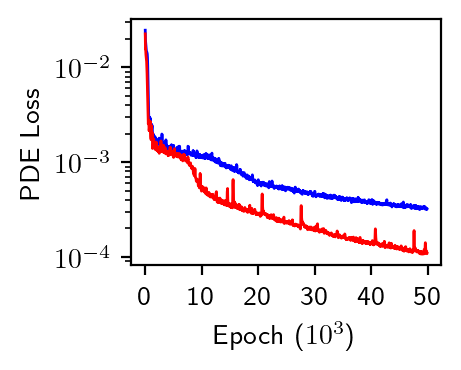

In [8]:
def moving_ave(series, window_size):
    """ Moving average to smooth the loss history a little bit """
    return np.convolve(series, np.ones(window_size) / window_size, mode='valid')


_, ax = plt.subplots(figsize=(5 / 2.5, 4 / 2.5), dpi=200)
seed_ = 2
hist_def = np.loadtxt(out_dir / f"{seed_}_{False}")[:, -1]
hist_kgi = np.loadtxt(out_dir / f"{seed_}_{True}")[:, -1]
ax.plot(np.arange(0, epochs // 20 - 3), moving_ave(hist_def, 5), label="No KGI", lw=1, c='b')
ax.plot(np.arange(0, epochs // 20 - 3), moving_ave(hist_kgi, 5), label="KGI", lw=1, c='r')
ax.set_xticks([0, 10000 // 20, 20000 // 20, 30000 // 20, 40000 // 20, 50000 // 20],
              [0, 10, 20, 30, 40, 50])
ax.set_ylabel("PDE Loss")
ax.set_xlabel("Epoch ($10^3$)")
ax.set_yscale("log")
plt.show()